In [1]:
import argparse
import numpy as np
import random

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors

plt.rcParams["figure.figsize"] = (10,10)

In [2]:
class TeleportPoint:
    def __init__(self, x, y, out_x, out_y, id):
        self.x =x
        self.y = y
        self.out_x = out_x
        self.out_y = out_y
        self.id = id

    @staticmethod
    def generate_output_point(n, taken_points):
        x = random.randrange(n)
        y = random.randrange(n)
        while any(filter(lambda p: p[0]==x and p[1]==y, taken_points)):
            x = random.randrange(n)
            y = random.randrange(n)
        taken_points.append((x,y))
        return x, y

class GridWorld:
    def __init__(self, n, barrier_probability, barrier_value, random_seed, teleport_count=2,
                 deathtrap_count=4, actions=None):
        random.seed(random_seed)
        self.n = n
        #0 - left, 1 - up, 2 - right, 3 -down
        self.actions = actions or [0, 1, 2, 3]
        self.e_x = random.randrange(n)
        self.e_y = random.randrange(n)
        self.rewards = (-1) * np.ones((n, n))
        self.teleports = []
        self.death_trap_value=-5000
        for i in range(n):
            for j in range(n):
                if i != self.e_x or j != self.e_y:
                    p = random.uniform(0, 1)
                    if p < barrier_probability:
                        self.rewards[i, j] = barrier_value
        taken_points = [(self.e_x, self.e_y)]
        for i in range(teleport_count):
            x, y = TeleportPoint.generate_output_point(self.n, taken_points)
            out_x, out_y = TeleportPoint.generate_output_point(self.n, taken_points)
            teleport = TeleportPoint(x=x, y=y, out_x=out_x, out_y=out_y, id=i)
            self.teleports.append(teleport)

        for i in range(deathtrap_count):
            x, y = TeleportPoint.generate_output_point(self.n, taken_points)
            self.rewards[x, y] = self.death_trap_value

        print(self.rewards)


    def prepare_data_for_plot(self, data):
        teleport_value = 105

        data[self.e_x, self.e_y] = 10
        _colors = ['red', 'grey', 'white', 'green', 'yellow']
        bounds = [self.death_trap_value, -11, -2, 0, 12, 100]
        for teleport in self.teleports:
            data[teleport.x, teleport.y] = teleport_value
            data[teleport.out_x, teleport.out_y] = teleport_value
        cmap = colors.ListedColormap(_colors)
        norm = colors.BoundaryNorm(bounds, cmap.N)

        return data, cmap, norm

    def draw_plot(self):
        data = self.rewards.copy()
        data, cmap, norm = self.prepare_data_for_plot(data)

        fig, ax = plt.subplots()
        ax.imshow(data, cmap=cmap, norm=norm)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, self.n, 1))
        ax.set_yticks(np.arange(-.5, self.n, 1))

        for teleport in self.teleports:
            text = ax.text( teleport.y, teleport.x, f'in_{teleport.id}', fontsize=10, ha="center", va="top", color="black")
            text = ax.text( teleport.out_y, teleport.out_x, f'out_{teleport.id}', fontsize=10, ha="center", va="top", color="black")

        fig.tight_layout()
        plt.show()

    def plot_optimal_actions(self, pi):
        data = self.rewards.copy()
        data, cmap, norm = self.prepare_data_for_plot(data)

        fig, ax = plt.subplots()
        ax.imshow(data, cmap=cmap, norm=norm)

        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, self.n, 1))
        ax.set_yticks(np.arange(-.5, self.n, 1))
        for i in range(self.n):
            for j in range(self.n):
                arrow = self.get_arrow(pi[i, j, :])
                text = ax.text(j, i, arrow, fontsize=16, ha="center", va="center", color="black")

        for teleport in self.teleports:
            text = ax.text( teleport.y, teleport.x, f'in{teleport.id}', fontsize=12, ha="right", verticalalignment="bottom", color="black")
            text = ax.text( teleport.out_y, teleport.out_x, f'out{teleport.id}', fontsize=12, ha="right", verticalalignment="bottom", color="black")
        ax.set_title("Policy")
        fig.tight_layout()

        red_patch = mpatches.Patch(color='red', label='Death trap')
        grey_patch = mpatches.Patch(color='grey', label='Simple block')
        green_patch = mpatches.Patch(color='green', label='Exit')
        yellow_patch = mpatches.Patch(color='yellow', label='Teleport')
        ax.legend(handles=[red_patch, grey_patch, green_patch, yellow_patch], bbox_to_anchor=(1.05, 1.0), loc='upper left')

        plt.show()


    @staticmethod
    def get_arrow(prob_arr):
        best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
        if len(best_actions) == 1:
            if 0 in best_actions:
                return r"$\leftarrow$"
            if 1 in best_actions:
                return r"$\uparrow$"
            if 2 in best_actions:
                return r"$\rightarrow$"
            else:
                return r"$\downarrow$"

        elif len(best_actions) == 2:
            if 0 in best_actions and 1 in best_actions:
                return r"$\leftarrow \uparrow$"
            elif 0 in best_actions and 2 in best_actions:
                return r"$\leftrightarrow$"
            elif 0 in best_actions and 3 in best_actions:
                return r"$\leftarrow \downarrow$"
            elif 1 in best_actions and 2 in best_actions:
                return r"$\uparrow \rightarrow$"
            elif 1 in best_actions and 3 in best_actions:
                return r"$\updownarrow$"
            elif 2 in best_actions and 3 in best_actions:
                return r"$\downarrow \rightarrow$"

        elif len(best_actions) == 3:
            if 0 not in best_actions:
                return r"$\updownarrow \rightarrow$"
            elif 1 not in best_actions:
                return r"$\leftrightarrow \downarrow$"
            elif 2 not in best_actions:
                return r"$\leftarrow \updownarrow$"
            else:
                return r"$\leftrightarrow \uparrow$"

        else:
            return r"$\leftrightarrow \updownarrow$"

    def update_bellman(self, v, old_v, x, y, pi, gamma):
        if x == self.e_x and y == self.e_y:
            return None
        total = 0
        for a in self.actions:
            s_prime_x, s_prime_y = self.get_next_state(x, y, a, self.n)
            total += pi[x, y, a] * (self.rewards[s_prime_x, s_prime_y] + gamma * old_v[s_prime_x, s_prime_y])
        v[x, y] = total

    def get_next_state(self, x, y, a, n):
        if a == 0:
            s_prime_x = x
            s_prime_y = max(0, y - 1)
        elif a == 1:
            s_prime_x = max(0, x - 1)
            s_prime_y = y
        elif a == 2:
            s_prime_x = x
            s_prime_y = min(n - 1, y + 1)
        else:
            s_prime_x = min(n - 1, x + 1)
            s_prime_y = y
        step_into_teleport = next(filter(lambda p: p.x==s_prime_x and p.y==s_prime_y, self.teleports), None)
        if step_into_teleport:
            return step_into_teleport.out_x, step_into_teleport.out_y
        return s_prime_x, s_prime_y

In [3]:
class PolicyIteration:
    @classmethod
    def run_policy_iteration(
            cls, n, barrier_probability, barrier_reward, value_func_intial, gamma, theta, random_seed,
            teleport_count=2,
            deathtrap_count=4,
    ):
        grid_world = GridWorld(
            n, barrier_probability, barrier_reward, random_seed,
            teleport_count=teleport_count, deathtrap_count=deathtrap_count
        )
        i = 0
        grid_world.draw_plot()
        value_func = value_func_intial * np.ones((n, n))
        value_func[grid_world.e_x, grid_world.e_y] = 0

        pi = 1 / 4 * np.ones((n, n, 4))
        #cls.draw_values(value_func, grid_world.n)
        grid_world.plot_optimal_actions(pi)

        policy_stable = False
        while not policy_stable:
            i += 1
            print(f'Policy step {i}')
            cls.policy_evaluation(grid_world, value_func, pi, gamma, theta)
            policy_stable = cls.policy_improvement(grid_world, value_func, pi, gamma)
            #grid_world.plot_optimal_actions(pi)
        print(f'Policy done in {i} steps')
        grid_world.plot_optimal_actions(pi)

    @classmethod
    def policy_evaluation(cls, grid_world, v, pi, gamma, theta):
        delta = theta + 1
        i = 0
        while delta >= theta:
            old_v = v.copy()
            delta = 0
            for x in range(grid_world.n):
                for y in range(grid_world.n):
                    grid_world.update_bellman(v, old_v, x, y, pi, gamma)
                    delta = max(delta, abs(old_v[x, y] - v[x, y]))
            i += 1
        #cls.draw_values(v, grid_world.n)
        print(f'Policy Evaluation done in {i} steps')

    @classmethod
    def policy_improvement(cls, grid_world, v, pi, gamma):
        policy_stable = True
        for x in range(grid_world.n):
            for y in range(grid_world.n):
                old_pi = pi[x, y, :].copy()
                best_actions = []
                max_v = None
                for a in grid_world.actions:
                    s_prime_x, s_prime_y = grid_world.get_next_state(x, y, a, grid_world.n)
                    curr_val = grid_world.rewards[s_prime_x, s_prime_y] + gamma * v[s_prime_x, s_prime_y]
                    if max_v is None:
                        max_v = curr_val
                        best_actions.append(a)
                    elif curr_val > max_v:
                        max_v = curr_val
                        best_actions = [a]
                    elif curr_val == max_v:
                        best_actions.append(a)
                cls.define_new_policy(pi, x, y, best_actions, grid_world.actions)
                if not (old_pi == pi[x, y, :]).all():
                    policy_stable = False

        return policy_stable


    @staticmethod
    def draw_values(v, n):
        fig, ax = plt.subplots()
        im = ax.imshow(v, cmap='YlOrBr', interpolation='nearest')
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-.5, n, 1))
        ax.set_yticks(np.arange(-.5, n, 1))
        for i in range(n):
            for j in range(n):
                text = ax.text(j, i, "{:.2f}".format(v[i, j]), ha="center", va="center", color="black")
        ax.set_title("Values")
        fig.tight_layout()
        plt.show()


    @staticmethod
    def define_new_policy(pi, x, y, best_actions, actions):
        prob = 1/len(best_actions)
        for a in actions:
            pi[x, y, a] = prob if a in best_actions else 0


[[-5.e+03 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+00 -1.e+00
  -1.e+00 -1.e+00 -5.e+03]
 [-5.e+03 -1.e+00 -5.e+00 -5.e+03 -5.e+03 -1.e+00 -1.e+00 -5.e+03 -1.e+00
  -5.e+00 -1.e+00 -1.e+00]
 [-1.e+00 -5.e+00 -1.e+00 -5.e+00 -1.e+00 -5.e+00 -1.e+00 -1.e+00 -1.e+00
  -1.e+00 -1.e+00 -5.e+00]
 [-1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+00 -1.e+00 -5.e+03 -1.e+00
  -1.e+00 -1.e+00 -1.e+00]
 [-1.e+00 -1.e+00 -1.e+00 -5.e+03 -1.e+00 -5.e+00 -5.e+00 -5.e+03 -1.e+00
  -1.e+00 -1.e+00 -1.e+00]
 [-5.e+03 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+03 -5.e+00 -1.e+00 -1.e+00
  -1.e+00 -5.e+00 -1.e+00]
 [-1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+00
  -5.e+00 -1.e+00 -1.e+00]
 [-5.e+03 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+00 -1.e+00
  -1.e+00 -1.e+00 -5.e+00]
 [-1.e+00 -5.e+00 -5.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -5.e+00 -1.e+00
  -1.e+00 -1.e+00 -1.e+00]
 [-1.e+00 -1.e+00 -5.e+03 -1.e+00 -1.e+00 -1.e+00 -5.e+00 -5.e+00 -1.e+00
  -5.e+00 -1.e+00

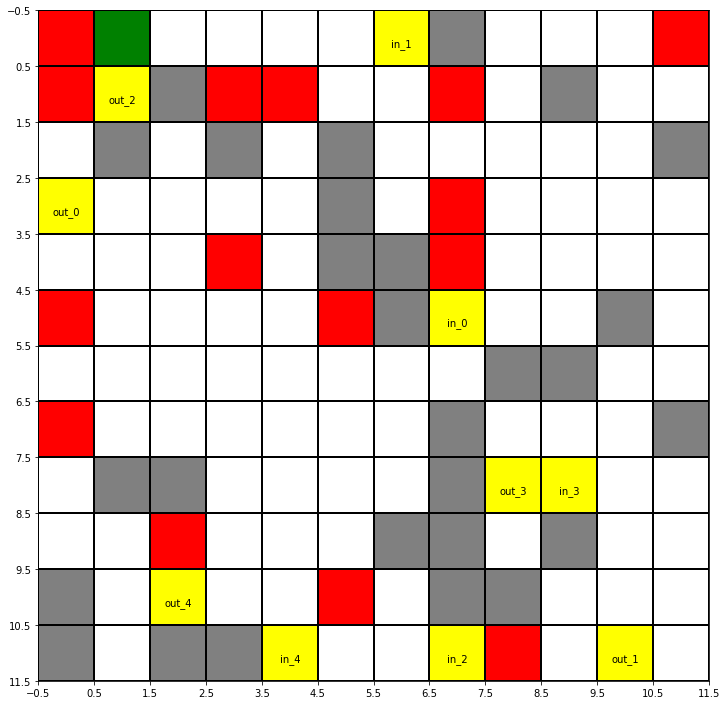

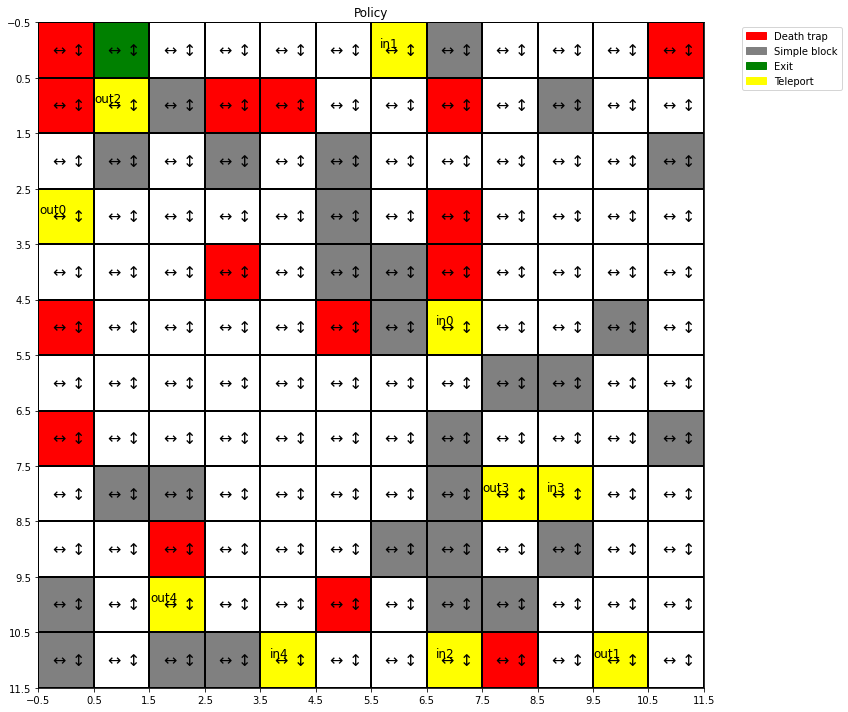

Policy step 1
Policy Evaluation done in 19 steps
Policy step 2
Policy Evaluation done in 18 steps
Policy step 3
Policy Evaluation done in 9 steps
Policy step 4
Policy Evaluation done in 3 steps
Policy step 5
Policy Evaluation done in 1 steps
Policy step 6
Policy Evaluation done in 1 steps
Policy step 7
Policy Evaluation done in 1 steps
Policy step 8
Policy Evaluation done in 1 steps
Policy step 9
Policy Evaluation done in 1 steps
Policy step 10
Policy Evaluation done in 1 steps
Policy step 11
Policy Evaluation done in 1 steps
Policy step 12
Policy Evaluation done in 1 steps
Policy step 13
Policy Evaluation done in 1 steps
Policy step 14
Policy Evaluation done in 1 steps
Policy step 15
Policy Evaluation done in 1 steps
Policy step 16
Policy Evaluation done in 1 steps
Policy step 17
Policy Evaluation done in 1 steps
Policy step 18
Policy Evaluation done in 1 steps
Policy done in 18 steps


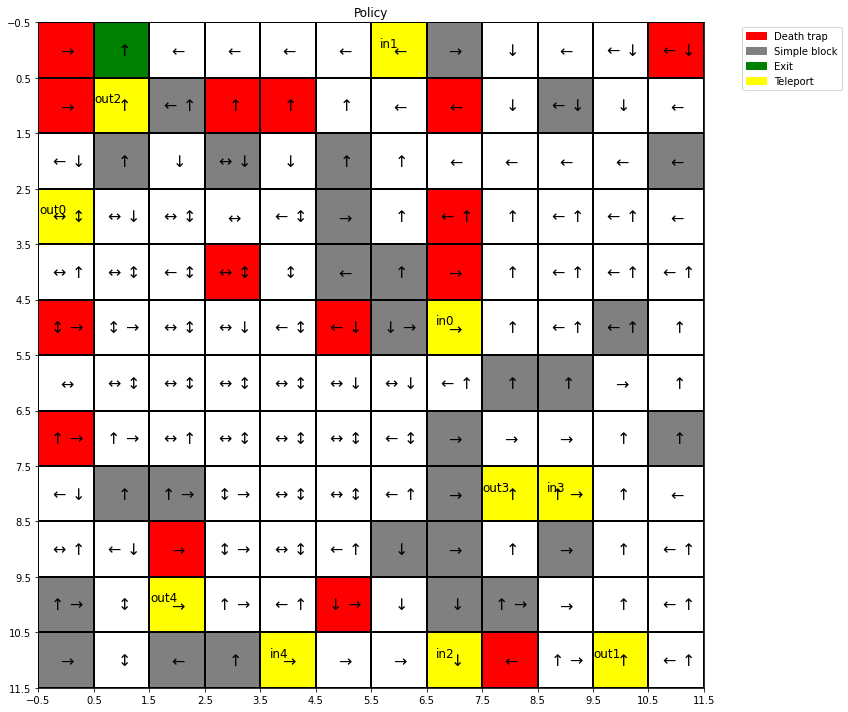

In [4]:
# grid_world = GridWorld(5, 0.3, -10, random_seed=123)
# i = 0
# grid_world.draw_plot()
PolicyIteration.run_policy_iteration(
    n=12,
    barrier_probability=0.3,
    barrier_reward=-5,
    value_func_intial=0,
    gamma=0.6,
    theta=0.1,
    random_seed=547,

    deathtrap_count=15,
    teleport_count=5
)
#721,

#algorithm 1: Policy Iteration

Policy iteration is the algorithm of